# Avoiding Over-fitting & Under fitting [500]

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


In [2]:
""" Load CIFAR-10 dataset """
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [4]:
import pandas as pd
all_lables = np.concatenate([train_labels, test_labels])
all_lables.shape = (60000,)

""" Number of classes """
print(pd.Series(all_lables).nunique())

10


In [5]:
print(train_images.shape, '|', train_labels.shape)

(50000, 32, 32, 3) | (50000, 1)


In [6]:
print(test_images.shape, '|', test_labels.shape)

(10000, 32, 32, 3) | (10000, 1)


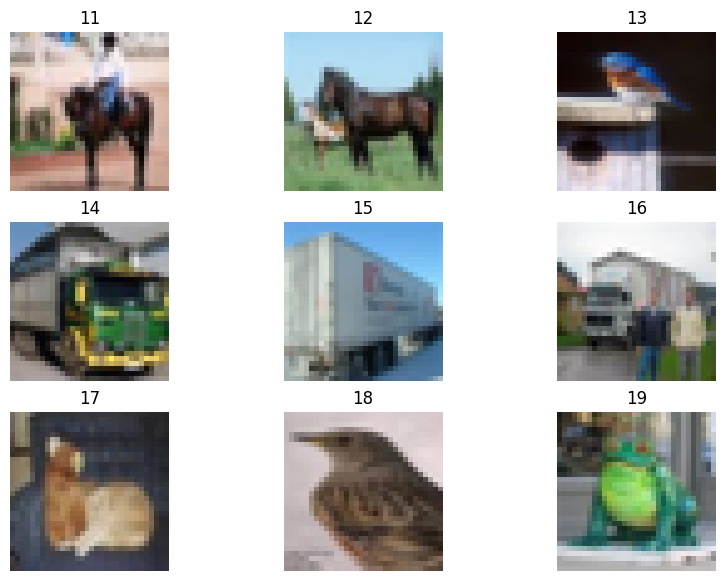

In [7]:
""" Display some samples """
fig = plt.figure(figsize=(10, 7))
for i in range(1, 10):
    fig.add_subplot(3, 3, i)

    plt.imshow(train_images[i+10], cmap='Greys')
    plt.axis('off')
    plt.title(f'{i+10}')


In [8]:
""" Normalize Data """
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
""" Split into training and validation data """
# Use 10 % of the train-set as validation-set.
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=123)
print(train_images.shape, '|', val_images.shape)

(45000, 32, 32, 3) | (5000, 32, 32, 3)


In [11]:
# Use Overfit prevention methods. [Batch Normalization, Earlystop, Dropout, Data augmentation, ...]!!!

In [12]:
""" Data augmentation """
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Concatenate original data with augmented data
augmented_data = []
augmented_labels = []

for x_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=len(train_images)):
    augmented_data.extend(x_batch)
    augmented_labels.extend(y_batch)
    if len(augmented_data) >= len(train_images):
        break

x_train_concat = np.concatenate((train_images, augmented_data[:len(train_images)]))
y_train_concat = np.concatenate((train_labels, augmented_labels[:len(train_labels)]))

# Shuffle the concatenated data
shuffle_idx = np.random.permutation(len(x_train_concat))
x_train_concat = x_train_concat[shuffle_idx]
y_train_concat = y_train_concat[shuffle_idx]

In [13]:
print(x_train_concat.shape, '|', y_train_concat.shape)

(90000, 32, 32, 3) | (90000, 1)


In [14]:
!pip install pydot
!sudo apt install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [15]:
from tensorflow.keras.utils import plot_model

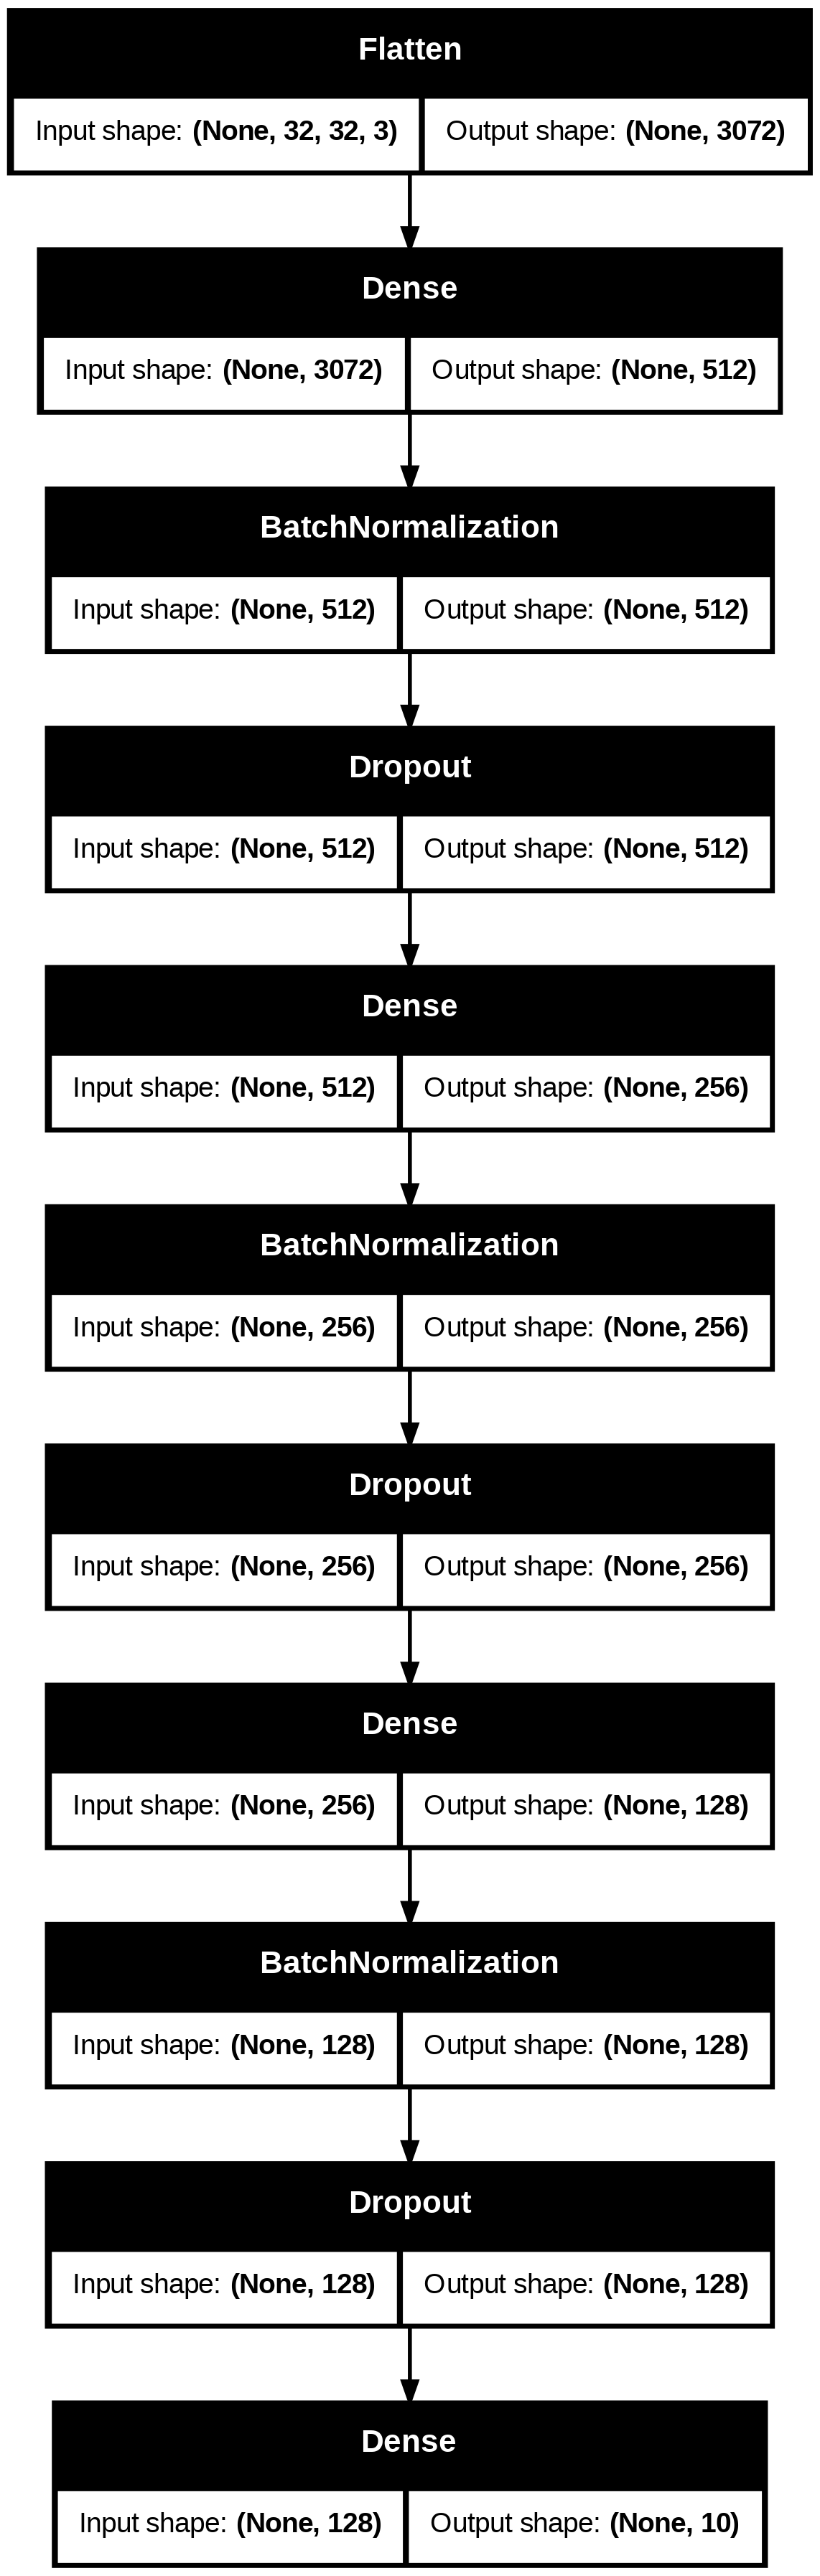

In [16]:
""" Construct the neural network """
# Use only the dense layer!
model = Sequential([
    Input((32, 32, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [17]:
""" Early stopping callback """
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
""" Train the model """
# Number of epochs: 50
history = model.fit(
    x_train_concat,
    y_train_concat,
    epochs=50,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]
  )


Epoch 1/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.3068 - loss: 1.9990 - val_accuracy: 0.3734 - val_loss: 1.7321
Epoch 2/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.3846 - loss: 1.7137 - val_accuracy: 0.4150 - val_loss: 1.6478
Epoch 3/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.3975 - loss: 1.6788 - val_accuracy: 0.4338 - val_loss: 1.5825
Epoch 4/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.4067 - loss: 1.6617 - val_accuracy: 0.4122 - val_loss: 1.6860
Epoch 5/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.4062 - loss: 1.6551 - val_accuracy: 0.4352 - val_loss: 1.5710
Epoch 6/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.4215 - loss: 1.6157 - val_accuracy: 0.4586 - val_loss: 1.5124
Epoch 7/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - accuracy: 0.4329 - loss: 1.5876 - val_accuracy: 0.4616 - val_loss: 1.4855
Epoch 8/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.4315 -

In [19]:
""" Evaluate the model on the test set """
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5266 - loss: 1.3411
Test loss: 1.3450953960418701
Test accuracy: 0.5206999778747559


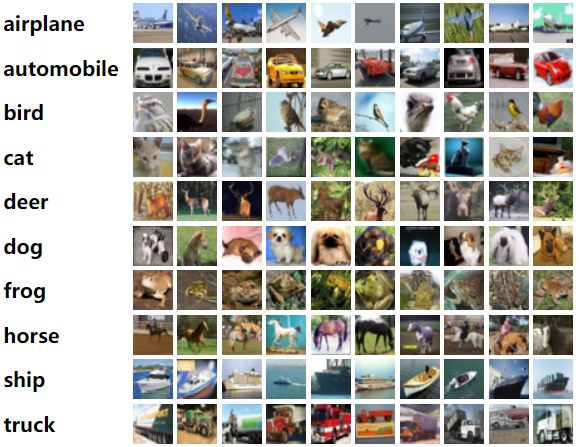

In [21]:
from IPython.display import Image
Image(filename='CIFAR-10_dataset_classes.png')

In [22]:
""" Classes Dictionary """
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

(32, 32, 3)


Text(0.5, 1.0, 'class_number: 5 | class_name: dog')

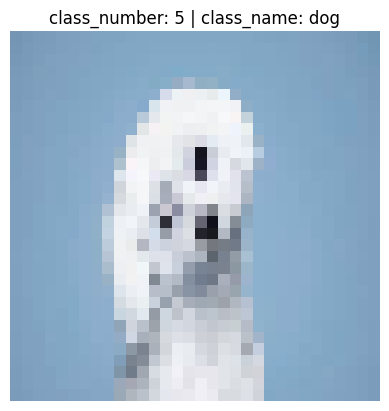

In [23]:
""" Load a test image for predict """
import cv2

test_img = cv2.imread('dog.jpeg')
test_img = cv2.resize(test_img, (32, 32))

print(test_img.shape)
plt.imshow(test_img, 'Greys')
plt.axis('off')
plt.title("class_number: 5 | class_name: dog")

In [24]:
""" Prediction step """
test_img = test_img.reshape(-1, 32, 32, 3)
predicted_class = np.argmax(model.predict(test_img), axis=1)
print('predicted_class_number:', predicted_class)
print('predicted_class_name:', f'[{classes.get(predicted_class[0])}]')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
predicted_class_number: [0]
predicted_class_name: [airplane]


In [25]:
""" Frame History """
data = pd.DataFrame(history.history)
data.head()

,accuracy,loss,val_accuracy,val_loss
0,0.343356,1.853939,0.3734,1.732088
1,0.388656,1.703216,0.4150,1.647789
2,0.399444,1.677969,0.4338,1.582466
3,0.406089,1.663008,0.4122,1.686036
4,0.412733,1.639132,0.4352,1.570981


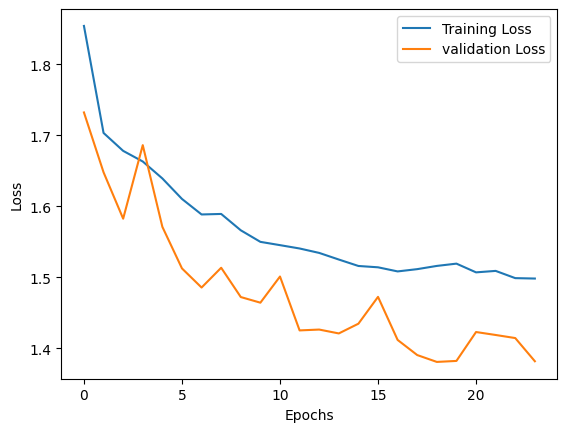

In [26]:
""" Loss plot """
plt.plot(range(data.shape[0]),data['loss'], label="Training Loss")
plt.plot(range(data.shape[0]),data['val_loss'],label="validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

 - Is your model suffering from overfitting or underfitting???

overffiting, Because in dense networks, the neighborhood of pixels has no effect on the result, that's why we go to overfitting in model training for our images.

## THNAK YOU --- \\(^o^)/